# Modificando data in situ.
&emsp;&emsp;&emsp;&emsp;**Basado en el tutorial introductorio de MNE: [Modifyinh data in-place](https://mne.tools/stable/auto_tutorials/intro/15_inplace.html)**

## ¿Que significa in situ?
Un algoritmo *in situ* o *in-place* es uno que no requiere espacio extra para producir un *output*, ya que lo produce en el mismo espacio de memoria que contiene la data al transformar el *input* in situ. Puede llegar a usarse un poco de espacio extra, pero en general, lo que sucede es que nuestro *input* original es reemplazado por el *output*, por lo que el primero se pierde.

## Modificaciones in situ con MNE-Python
Muchas de los objetos de MNE-Python tienen métodos para modificar su data in situ, ya sean opcionales u obligatorios. Esto puede ser ventajoso cuando se está trabajando con datasets grandes ya que reduce la cantidad de memoria necesaria para las computaciones. Sin embargo, puede llevar a resultados inesperados si no eres consciente de que está pasando. Este tutorial brinda algunos ejemplos de procesamiento in situ, y cuando y cómo evitarlos. 

Empezaremos cargando la librería MNE-Python y alguna data de ejemplo:

In [20]:
import mne

sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = sample_data_folder / "MEG" / "sample" / "sample_audvis_raw.fif"
raw = mne.io.read_raw_fif(sample_data_raw_file, preload=True)
raw.crop(tmax=10.0)  # raw.crop() siempre actúa in situ

Opening raw data file C:\Users\J-Est\mne_data\MNE-sample-data\MEG\sample\sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...


Measurement date,"December 03, 2002 19:01:10 GMT"
Experimenter,MEG
Participant,Unknown
Digitized points,146 points
Good channels,"203 Gradiometers, 102 Magnetometers, 9 Stimulus, 59 EEG, 1 EOG"
Bad channels,"MEG 2443, EEG 053"
EOG channels,EOG 061
ECG channels,Not available
Sampling frequency,600.61 Hz
Highpass,0.10 Hz
Lowpass,172.18 Hz


### 1. Procesamiento de señales

La mayoría de objetos de data de MNE-Python poseen métodos para el filtrado, incluyendo filtros pasa bajas y altas (`filter`), band-stop(`notch_filter`), Hilbert transforms(`apply_hilbert`) e incluso funciones arbitrarias o definidas por el usuario(`apply_function`). Estas, típicamente, son siempre modificaciones in situ, así que **si queremos preservar la data sin procesar, debemos realizar una copia de esta**:

In [21]:
original_raw = raw.copy()
raw.apply_hilbert()
print(f"La data original era de tipo {original_raw.get_data().dtype}," 
      f" y la data transformada es de tipo {raw.get_data().dtype}")

La data original era de tipo float64, y la data transformada es de tipo complex128


### 2. Escogiendo canales.
Otro grupo de métodos donde la data es modificada in situ son métodos de escoger canales:

In [22]:
print(f"La data original tenía {original_raw.info['nchan']} canales")
original_raw.pick("eeg") # Seleccionamos solo los canales de EEG
print(f"Luego de escoger los canales de EEG, tiene {original_raw.info['nchan']} canales")

La data original tenía 376 canales
Luego de escoger los canales de EEG, tiene 60 canales


Al escoger solo los canales de EEG, se desecharon también las proyecciones relacionadas con magnetómetros y demás

### 3. Parámetro `copy`.

Anteriormente hemos usado el método `copy`para facilitar la comparación de data antes y después del procesado. Esto no es necesario al usar ciertas funciones de MNE-Python, ya que tienen su propio parámetro booleano `copy`, el cual al ser `=True` retorna una copia modificada de la data, de lo contrario, al ser `=False` actúa in situ. 

Por ejemplo, `mne.set_eeg_reference` posee este parámetro:

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Using matplotlib as 2D backend.


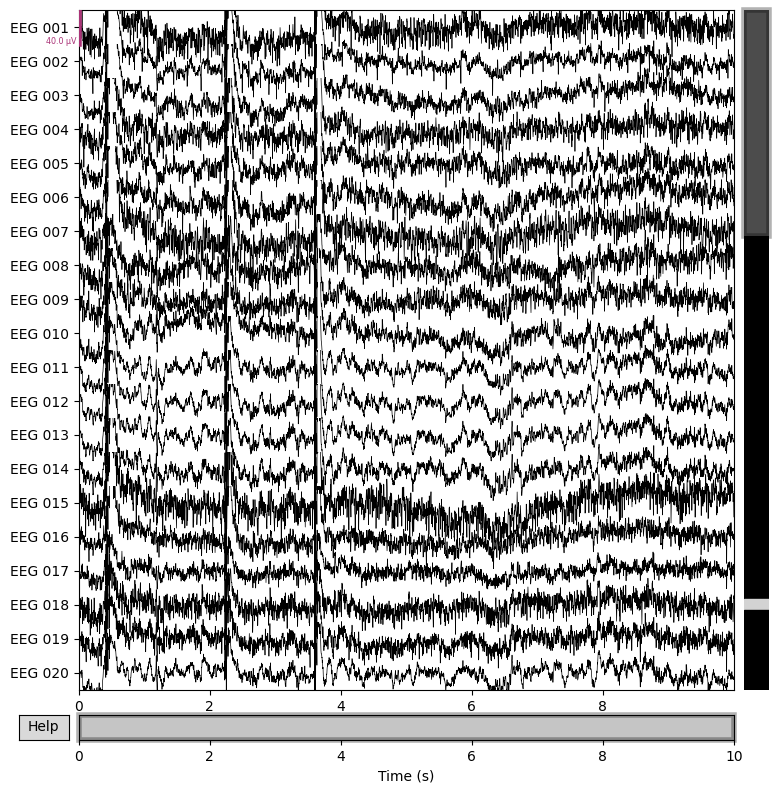

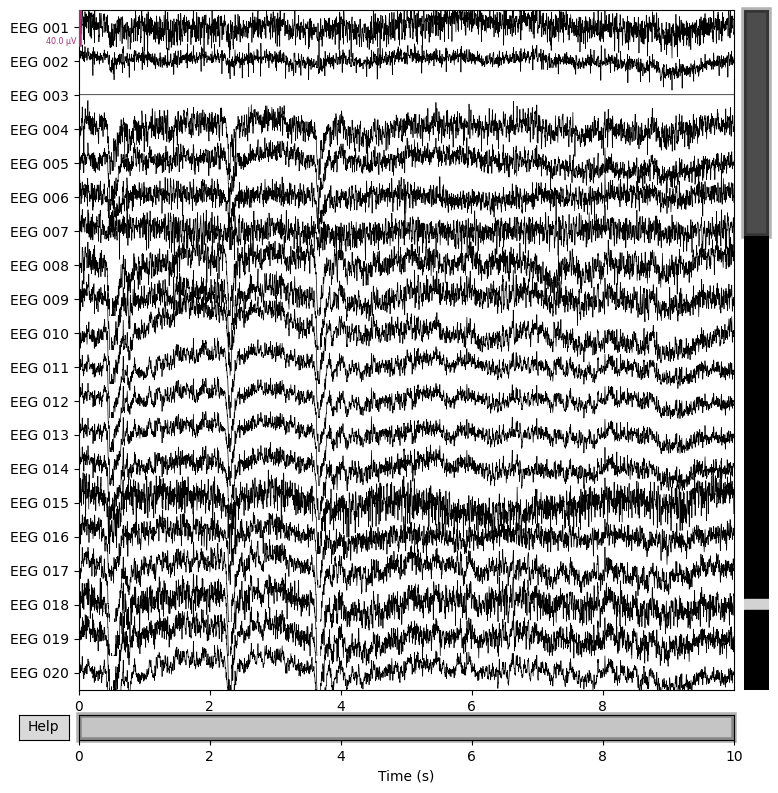

In [23]:
referenced_raw, ref_data = mne.set_eeg_reference(original_raw, ["EEG 003"], copy=True)
fig_orig = original_raw.plot()
fig_ref = referenced_raw.plot()

## Conclusiones.

En general, debes esperar que métodos de objetos con data (`Raw`, `Epochs`, `Evoked`...) operen in situ, mientras que funciones que usan como parámetros alguno de estos objetos operen en una copia de la data (a no ser que la función tenga un parámetro `copy` y su valor predeterminado sea `False` o lo definas como tal).

En las fases exploratorias de tus análisis, deberías acostumbrarte a trabajar con copias de tu data para así evitar tener que volver a cargarla y repetir pasos previos cada vez que cambias alguna data.